Reading expression data...
Reading metadata...
Processing data in chunks...
Processed chunk 1/13
Processed chunk 2/13
Processed chunk 3/13
Processed chunk 4/13
Processed chunk 5/13
Processed chunk 6/13
Processed chunk 7/13
Processed chunk 8/13
Processed chunk 9/13
Processed chunk 10/13
Processed chunk 11/13
Processed chunk 12/13
Processed chunk 13/13
Standardizing features...
Performing PCA...
Creating visualization...
Visualization saved to /home/romainlhardy/code/hyperbolic-cancer/data/lungpca_visualization.png
PCA results saved to /home/romainlhardy/code/hyperbolic-cancer/data/lungpca_results.tsv


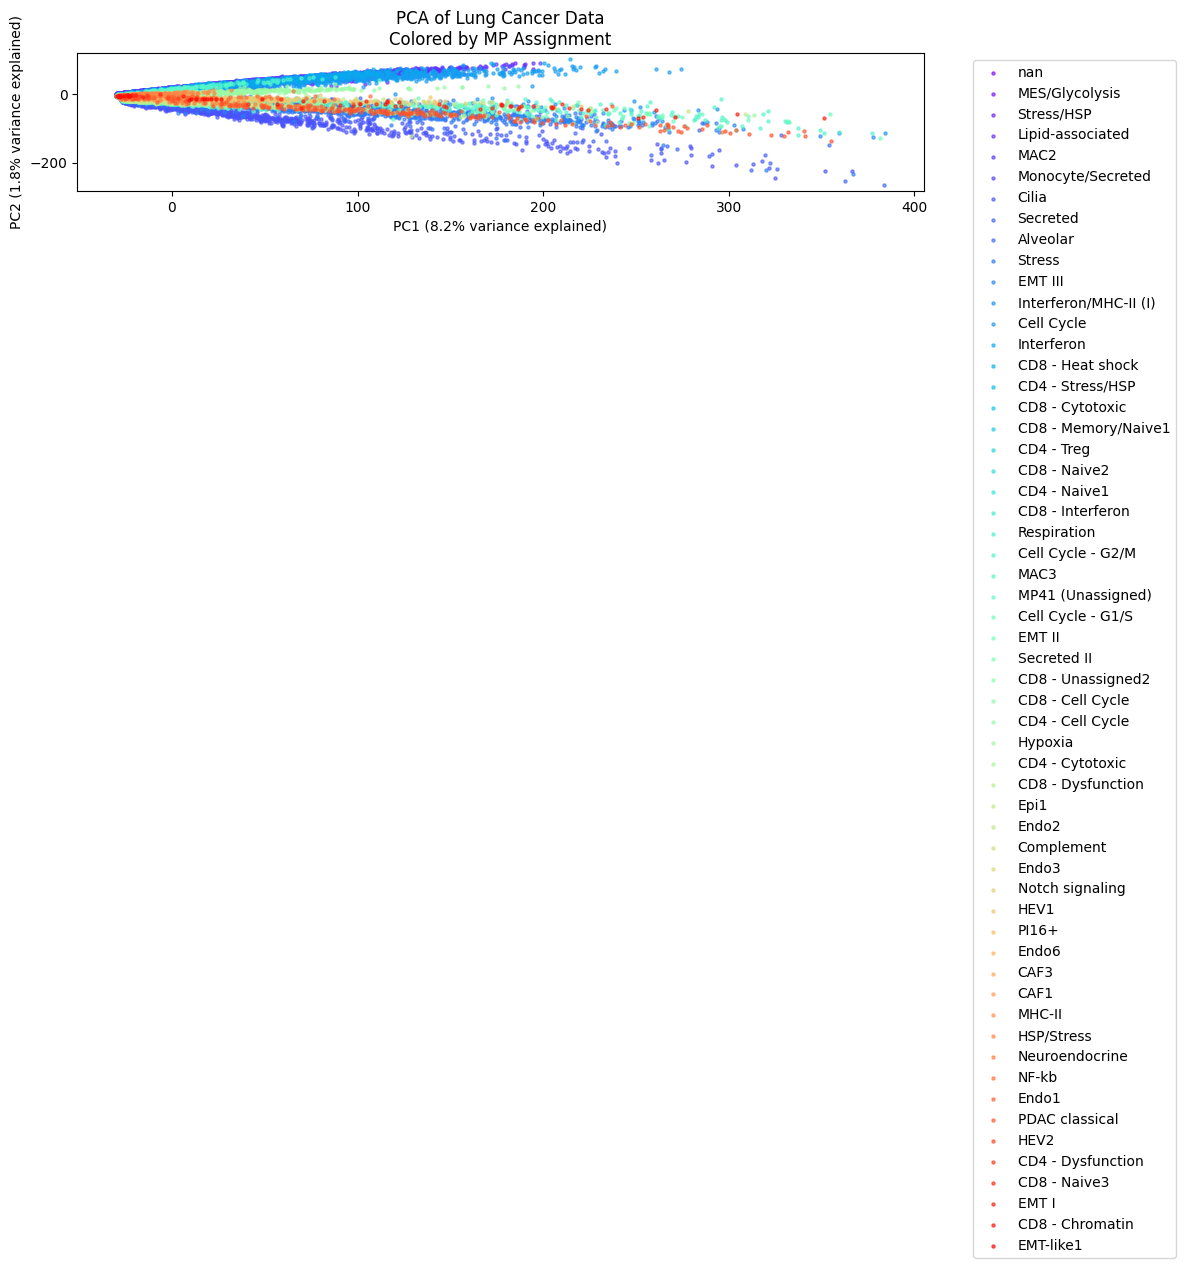

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.sparse as sp
# from scphere.util.util import read_mtx
from scipy.io import mmread
import gc

# Set paths
data_dir = './example/data/lung_cancer/'
save_path = '/home/romainlhardy/code/hyperbolic-cancer/data/lung'

# Read the expression data
print("Reading expression data...")
# mtx = data_dir + 'counts.mtx'
x = mmread("/home/romainlhardy/code/hyperbolic-cancer/data/lung/Exp_data_UMIcounts.mtx")
x = sp.csr_matrix(x.transpose())  # genes x cells -> cells x genes

# Read metadata
print("Reading metadata...")
metadata = pd.read_csv("/home/romainlhardy/code/hyperbolic-cancer/data/lung/metadata.tsv", sep='\t')

# Process data in chunks due to memory constraints
print("Processing data in chunks...")
chunk_size = 10000
n_chunks = (x.shape[0] + chunk_size - 1) // chunk_size
x_processed = []

for i in range(n_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, x.shape[0])
    
    # Get chunk and convert to dense
    x_chunk = x[start_idx:end_idx].todense()
    
    # Log transform: log(1 + x)
    x_chunk = np.log1p(x_chunk)
    
    x_processed.append(x_chunk)
    print(f"Processed chunk {i+1}/{n_chunks}")

x_processed = np.asarray(np.vstack(x_processed))
del x
gc.collect()

# Standardize the features
print("Standardizing features...")
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_processed)
del x_processed
gc.collect()

# Perform PCA
print("Performing PCA...")
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_scaled)

# Create the plot
print("Creating visualization...")
plt.figure(figsize=(12, 8))

# Create color mapping for mp_assignments
unique_assignments = metadata['mp_assignment'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_assignments)))
color_dict = dict(zip(unique_assignments, colors))

# Plot each mp_assignment group
for assignment in unique_assignments:
    mask = metadata['mp_assignment'] == assignment
    plt.scatter(x_pca[mask, 0], x_pca[mask, 1], 
               c=[color_dict[assignment]], 
               label=assignment,
               alpha=0.6,
               s=5)  # smaller point size for better visibility

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance explained)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance explained)')
plt.title('PCA of Lung Cancer Data\nColored by MP Assignment')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
plt.savefig(save_path + 'pca_visualization.png', dpi=300, bbox_inches='tight')
print(f"Visualization saved to {save_path + 'pca_visualization.png'}")

# Save PCA coordinates with metadata
results = pd.DataFrame({
    'PC1': x_pca[:, 0],
    'PC2': x_pca[:, 1],
    'mp_assignment': metadata['mp_assignment']
})
results.to_csv(save_path + 'pca_results.tsv', sep='\t', index=False)
print(f"PCA results saved to {save_path + 'pca_results.tsv'}") 

Visualization saved to /home/romainlhardy/code/hyperbolic-cancer/data/lungpca_visualization.png
PCA results saved to /home/romainlhardy/code/hyperbolic-cancer/data/lungpca_results.tsv


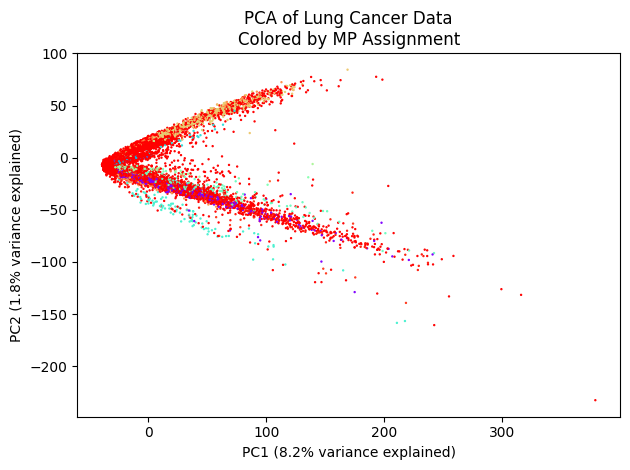

In [16]:
# Plot each mp_assignment group
patients = pd.read_csv("/home/romainlhardy/code/hyperbolic-cancer/data/lung/batch.tsv", sep="\t", header=None).values
filter = patients[:, 0] == 9
# filter = np.array([True] * len(patients))

cell_type_path = "/home/romainlhardy/code/hyperbolic-cancer/data/lung/metadata.tsv"
cell_types = pd.read_csv(cell_type_path, sep="\t")["mp_assignment"].replace(np.nan, "Unknown").values

unique_cell_types = np.unique(cell_types)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_cell_types)))
color_map = dict(zip(unique_cell_types, colors))
point_colors = [color_map[cell_type] for cell_type in cell_types]

# for assignment in unique_assignments:
#     mask = (metadata['mp_assignment'] == assignment) & filter
#     plt.scatter(x_pca[mask, 0], x_pca[mask, 1], 
#                c=[color_dict[assignment]], 
#                label=assignment,
#                alpha=0.6,
#                s=5)  # smaller point size for better visibility
plt.scatter(x_pca[filter, 0], x_pca[filter, 1], c=np.array(point_colors)[filter], s=0.5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance explained)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance explained)')
plt.title('PCA of Lung Cancer Data\nColored by MP Assignment')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
plt.savefig(save_path + 'pca_visualization.png', dpi=300, bbox_inches='tight')
print(f"Visualization saved to {save_path + 'pca_visualization.png'}")

# Save PCA coordinates with metadata
results = pd.DataFrame({
    'PC1': x_pca[:, 0],
    'PC2': x_pca[:, 1],
    'mp_assignment': metadata['mp_assignment']
})
results.to_csv(save_path + 'pca_results.tsv', sep='\t', index=False)
print(f"PCA results saved to {save_path + 'pca_results.tsv'}") 